# Scripts

In [199]:
%run '../shared-code/utils.py'

<Figure size 640x480 with 0 Axes>

# Dependencies

In [200]:
import pandas as pd 
from sklearn.svm import SVR
import seaborn as sns 
import joblib
import sklearn
import copy 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV,train_test_split,LeaveOneOut
from sklearn.model_selection import cross_val_score
import scipy
from sklearn.experimental import enable_halving_search_cv

%matplotlib inline 

# Utils 

In [201]:
def plot_3d_cv_results(fine_tuner,xs,ys,x_name,y_name):
    splits_keys=[f'split{i}_test_score' for i in range(6)]
    cv_res=fine_tuner.cv_results_
    split_matrix=[]
    for split_key in splits_keys:
        split_matrix.append(cv_res[split_key])
    split_matrix=np.array(split_matrix)
    split_matrix=split_matrix.T
    cv_avrgs=[]
    for split in split_matrix:
        cv_avrgs.append(np.mean(split))

    x=[]
    y=[]

    for p in fine_tuner.cv_results_['params']: 
        x.append(p[x_name])
        y.append(p[y_name])

    x_grid = np.linspace(min(xs), max(xs), 100)
    y_grid = np.linspace(min(ys), max(ys), 100)
    x_ratio_grid, y_ratio_grid = np.meshgrid(x_grid, y_grid)

    Z = scipy.interpolate.griddata(
        (x, y),
        cv_avrgs,
        (x_ratio_grid, y_ratio_grid),
        method='linear'
    )

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x_ratio_grid, y_ratio_grid, Z, cmap='viridis')
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel('CV Score')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Load & Process datasets  

In [202]:
tr=pd.read_csv('../data/train.csv',index_col=INDEX_COL)
tr.sample(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Index,,,,,,,,,,,,,,,,,,,,,
800,801,60,RL,79.0,12798,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,400,5,2008,WD,Normal,200000
832,833,60,RL,44.0,9548,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,237000


In [280]:
X_tr,y_tr=tr.drop(TARGET_COL,axis=1),tr[TARGET_COL]

In [204]:
data_pipe:sklearn.pipeline.Pipeline=joblib.load('../pipelines/data_pipeline.pkl')
data_pipe.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x74ddc663ef80>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x74dddaa3a680>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x74ddc663d7e0>))])

In [205]:
test=pd.read_csv('../data/test.csv')
X_test,y_test=test.drop(TARGET_COL,axis=1),test[TARGET_COL]

## Pretpostavki

- High dimensional kernels nemat da imat golemo vlijanie, zaradi golemata dimensionalnost na datasetot.  

# Scalling the data 

In [206]:
data_pipe_scalling=copy.deepcopy(data_pipe)
data_pipe_scalling.steps.append(("Scalling",StandardScaler()))
data_pipe_scalling.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x74ddc663ef80>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x74dddaa3ba00>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x74ddc663d7e0>)),
                ('Scalling', StandardScaler())])

In [281]:
X_tr_scalled,X_test_scalled=data_pipe_scalling.transform(X_tr), \
    data_pipe_scalling.transform(X_test)

## Linear kernel 

Bidejki varijansata na vakvime modeli e dosta golema parametrite mora da gi odberime preku cross validation. 

In [208]:
C_VALS=np.logspace(start=1,stop=20,base=0.1)
C_VALS=np.concatenate([C_VALS,np.logspace(start=1,stop=5,base=10)])
ERR_COEF=np.linspace(0,1,num=10)

In [209]:
svm=SVR(kernel='linear',max_iter=int(10e4))
fine_tuner=GridSearchCV(
    estimator=svm,
    param_grid={
        "C":C_VALS,
        "epsilon":[e*y_tr.min() for e in ERR_COEF ]
    },
    cv=6,
    scoring=house_pricing_metric,
    n_jobs=-1
)
fine_tuner.fit(X_tr_scalled,y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/si

GridSearchCV(cv=6, estimator=SVR(kernel='linear', max_iter=100000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 4.09491506e-02, 1.67683294e-02, 6.86648845e-03,
       2.81176870e-03, 1.15139540e-03, 4.71486636e-04, 1.93069773e-04,
       7.90604321e-05, 3.23745754e-05, 1.32571137e-05, 5.42867544e-06,
       2.22299648e-06, 9.10298178e-07, 3.72759372e-07, 1.52641797e-07,
       6.25055193e-...
       2.68269580e+04, 3.23745754e+04, 3.90693994e+04, 4.71486636e+04,
       5.68986603e+04, 6.86648845e+04, 8.28642773e+04, 1.00000000e+05]),
                         'epsilon': [0.0, 3877.7777777777774, 7755.555555555555,
                                     11633.333333333332, 15511.11111111111,
                                     19388.88888888889, 23266.666666666664,
                                     27144.44444444444, 31022.22222222222,
                                     34900.0]},
             scoring=make_scorer(rmse_logs, response_method='predict'))

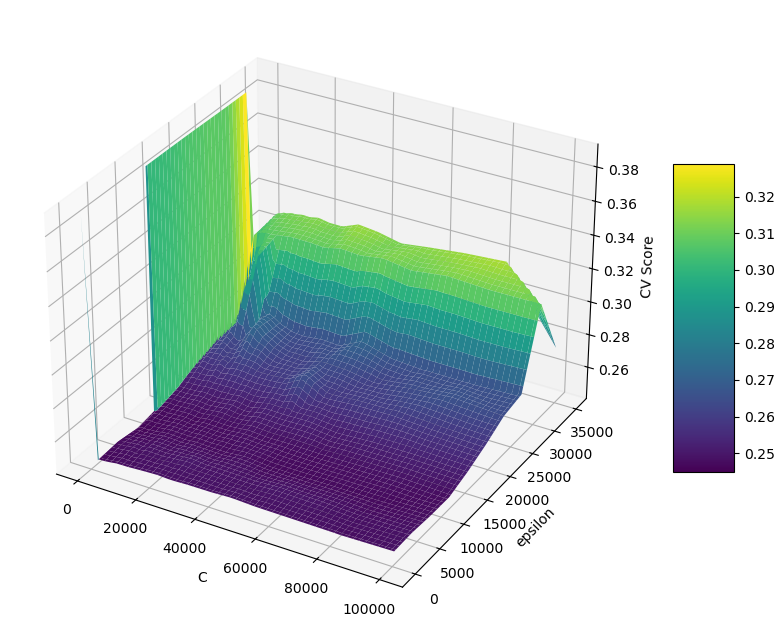

In [210]:
plot_3d_cv_results(fine_tuner=fine_tuner,xs=C_VALS,ys=[e*y_tr.min() for e in ERR_COEF],x_name='C',y_name='epsilon')

In [211]:
svm=SVR(kernel='linear',max_iter=int(10e4))
C_VALS=np.logspace(start=1,base=0.1,stop=20)
fine_tuner=GridSearchCV(
    estimator=svm,
    param_grid={
        "C":C_VALS,
        "epsilon":[e*y_tr.min() for e in ERR_COEF ]
    },
    cv=6,
    scoring=house_pricing_metric,
    n_jobs=-1
)
fine_tuner.fit(X_tr_scalled,y_tr)

GridSearchCV(cv=6, estimator=SVR(kernel='linear', max_iter=100000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 4.09491506e-02, 1.67683294e-02, 6.86648845e-03,
       2.81176870e-03, 1.15139540e-03, 4.71486636e-04, 1.93069773e-04,
       7.90604321e-05, 3.23745754e-05, 1.32571137e-05, 5.42867544e-06,
       2.22299648e-06, 9.10298178e-07, 3.72759372e-07, 1.52641797e-07,
       6.25055193e-...
       3.08884360e-17, 1.26485522e-17, 5.17947468e-18, 2.12095089e-18,
       8.68511374e-19, 3.55648031e-19, 1.45634848e-19, 5.96362332e-20,
       2.44205309e-20, 1.00000000e-20]),
                         'epsilon': [0.0, 3877.7777777777774, 7755.555555555555,
                                     11633.333333333332, 15511.11111111111,
                                     19388.88888888889, 23266.666666666664,
                                     27144.44444444444, 31022.22222222222,
                                     34900.0]},
             scoring=make_scorer(rmse_logs, response_method='predict'))

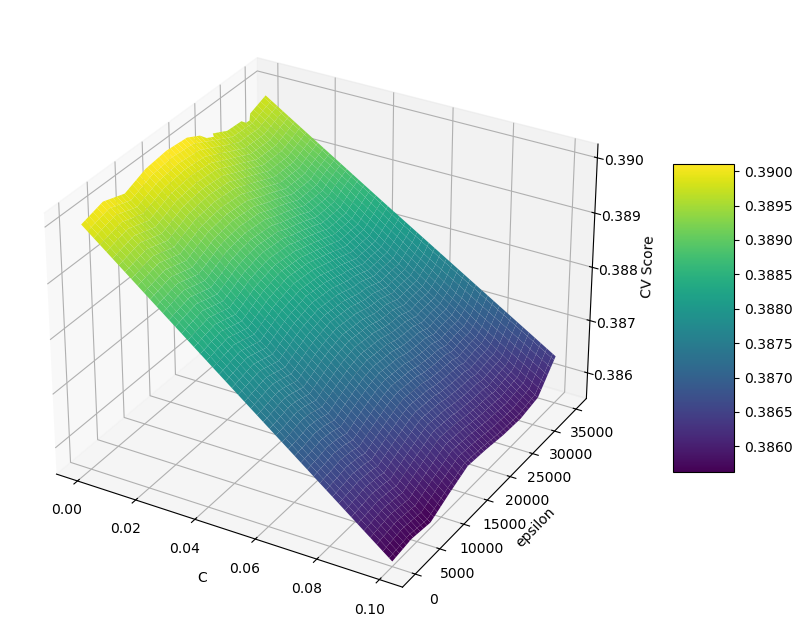

In [212]:
plot_3d_cv_results(fine_tuner=fine_tuner,xs=C_VALS,ys=[e*y_tr.min() for e in ERR_COEF],x_name='C',y_name='epsilon')

Zaradi conveksnota na SVM sigurni sme deka naidovme na globalen minimum.

In [213]:
fine_tuner.best_score_

0.39015044380633795

Znachit deka i najdobriot model ne e bash podobar od linearna regresija. 

In [214]:
fine_tuner.best_params_

{'C': 2.6826957952797296e-15, 'epsilon': 15511.11111111111}

In [215]:
best_svm=fine_tuner.best_estimator_
best_svm.fit(X_tr_scalled,y_tr)

SVR(C=2.6826957952797296e-15, epsilon=15511.11111111111, kernel='linear',
    max_iter=100000)

In [216]:
rmse_logs(y_test,best_svm.predict(X_test_scalled))

0.43217296623422585

Dosta losh score za test datasetot. 

Ochekuvano deka sepak najdobriot na validation setot vagashe 0.39 rmse_logs.

## Objasnuvanje na errorot

Errot e dosta chuden bidejki linear regression davashe podobri rezultati od ova. Edinstvenata razlika pomegu ovie 2 modeli e toa shto edniot go zemat najmaliot error pri fitvenje dodeka drugiot ostavat epsilon greshka pomegu features. 

Pretopostavuvam deka faktot deka SVR barat generalen epsilon za site samples, dodeka pak LinearRegression izbirat epsilon za sekoj sample posebno (odnosno barat kombinacija na epsilons t.s. celosniot error bi se namalil), ke e voditel vo toa shto SVR(kernel='line') ne gi postignuva istite rezultati.

Vaka ke napreme za da ja proverime pretpostavkata. Najprvin da ja vizuelizirame granicata na predictions na koi mu asocirame 0 penalty.

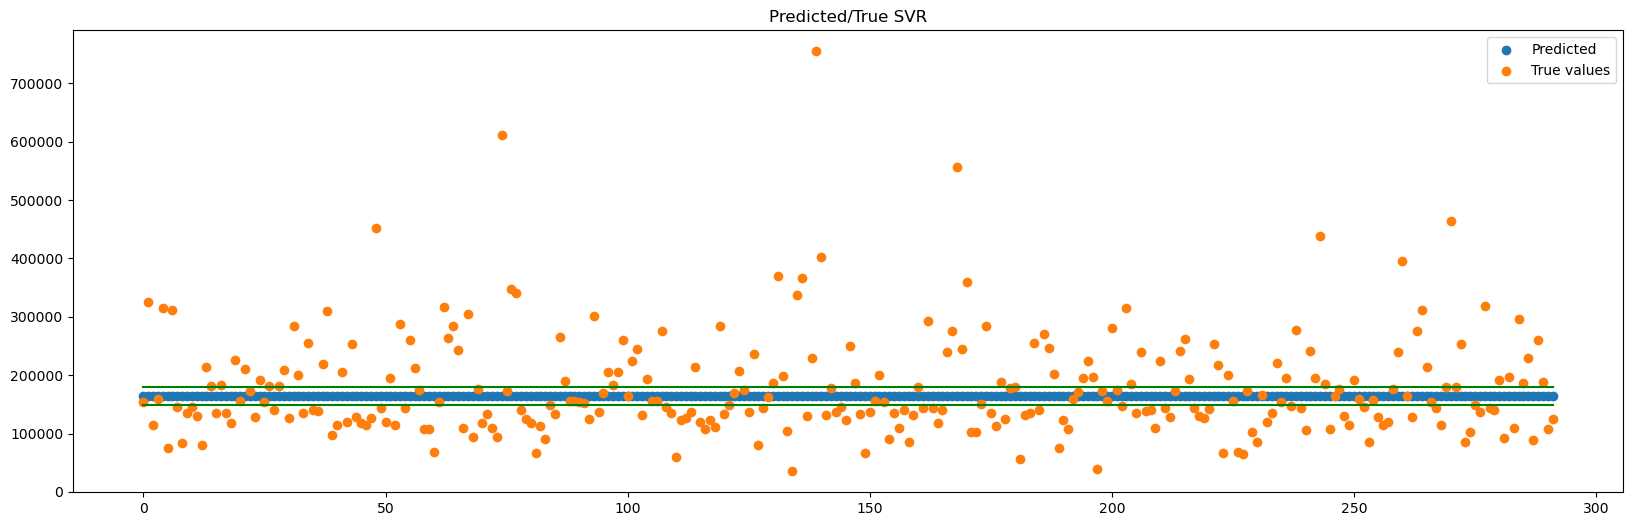

In [217]:
y_pred=best_svm.predict(X_test_scalled)
best_epsilon=fine_tuner.best_params_['epsilon']

plt.figure(figsize=(20,6))

plt.title("Predicted/True SVR")

plt.scatter(x=X_test.index.values,y=y_pred,label='Predicted')
plt.scatter(x=X_test.index.values,y=y_test,label='True values')

plt.legend()

plt.plot(X_test.index.values,[y+best_epsilon for y in y_pred],label='Decision+Epsilon',c='g')
plt.plot(X_test.index.values,[y-best_epsilon for y in y_pred],label='Decision-Epsilon',c='g')

plt.show() 

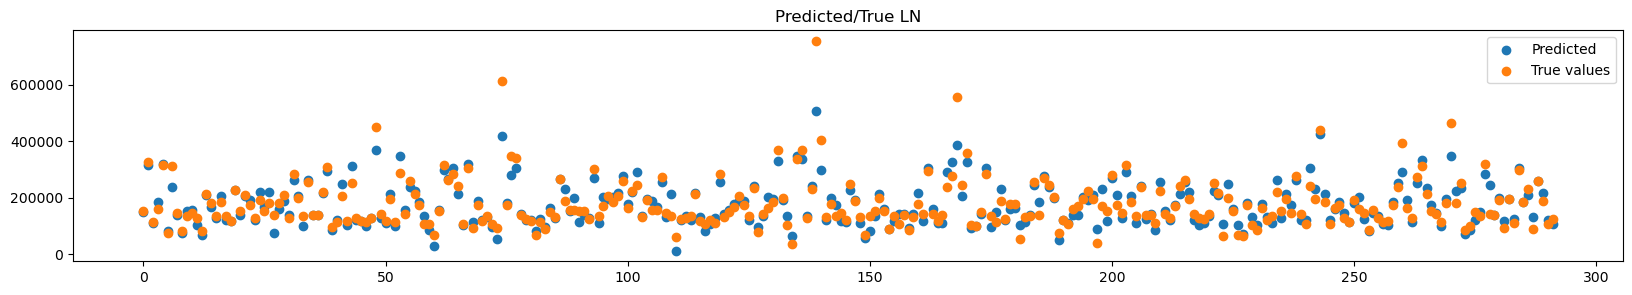

In [218]:
ln=sklearn.linear_model.LinearRegression()
ln.fit(X_tr_scalled,y_tr)

y_pred=ln.predict(X_test_scalled)

plt.figure(figsize=(20,3))

plt.title("Predicted/True LN")

plt.scatter(x=X_test.index.values,y=y_pred,label='Predicted')
plt.scatter(x=X_test.index.values,y=y_test,label='True values')

plt.legend()
plt.show() 

Imat smisla ova deka sepak e high dimensonal space pa posle ko ke gi mapirame vo lower dimensional space stanvat nelinearni.

Da probame so epsilon=0 

In [219]:
lin_svm=SVR(kernel='linear',epsilon=0,C=1e6,max_iter=int(10e6))
lin_svm.fit(X_tr_scalled,y_tr)
rmse_logs(y_test,lin_svm.predict(X_test_scalled))

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.18804471381416718

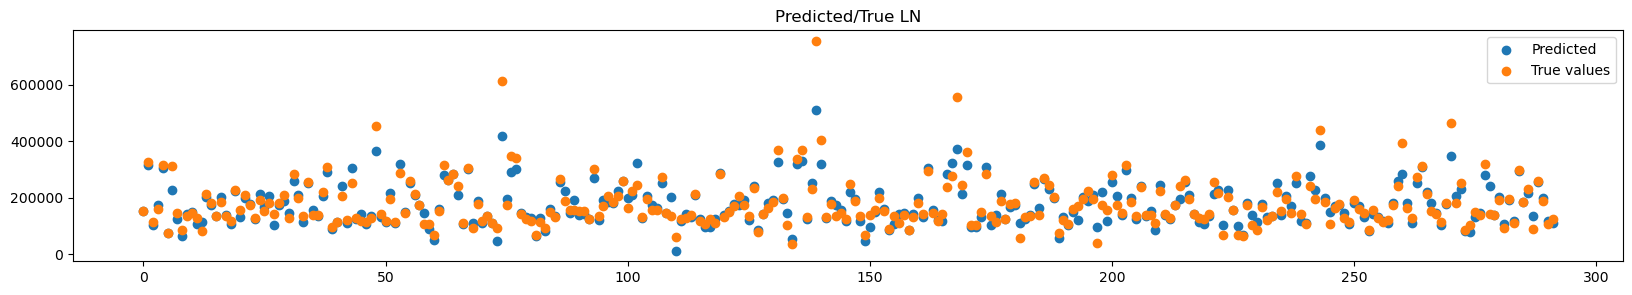

In [220]:
y_pred=lin_svm.predict(X_test_scalled)

plt.figure(figsize=(20,3))
plt.title("Predicted/True LN")

plt.scatter(x=X_test.index.values,y=y_pred,label='Predicted')
plt.scatter(x=X_test.index.values,y=y_test,label='True values')

plt.legend()
plt.show() 

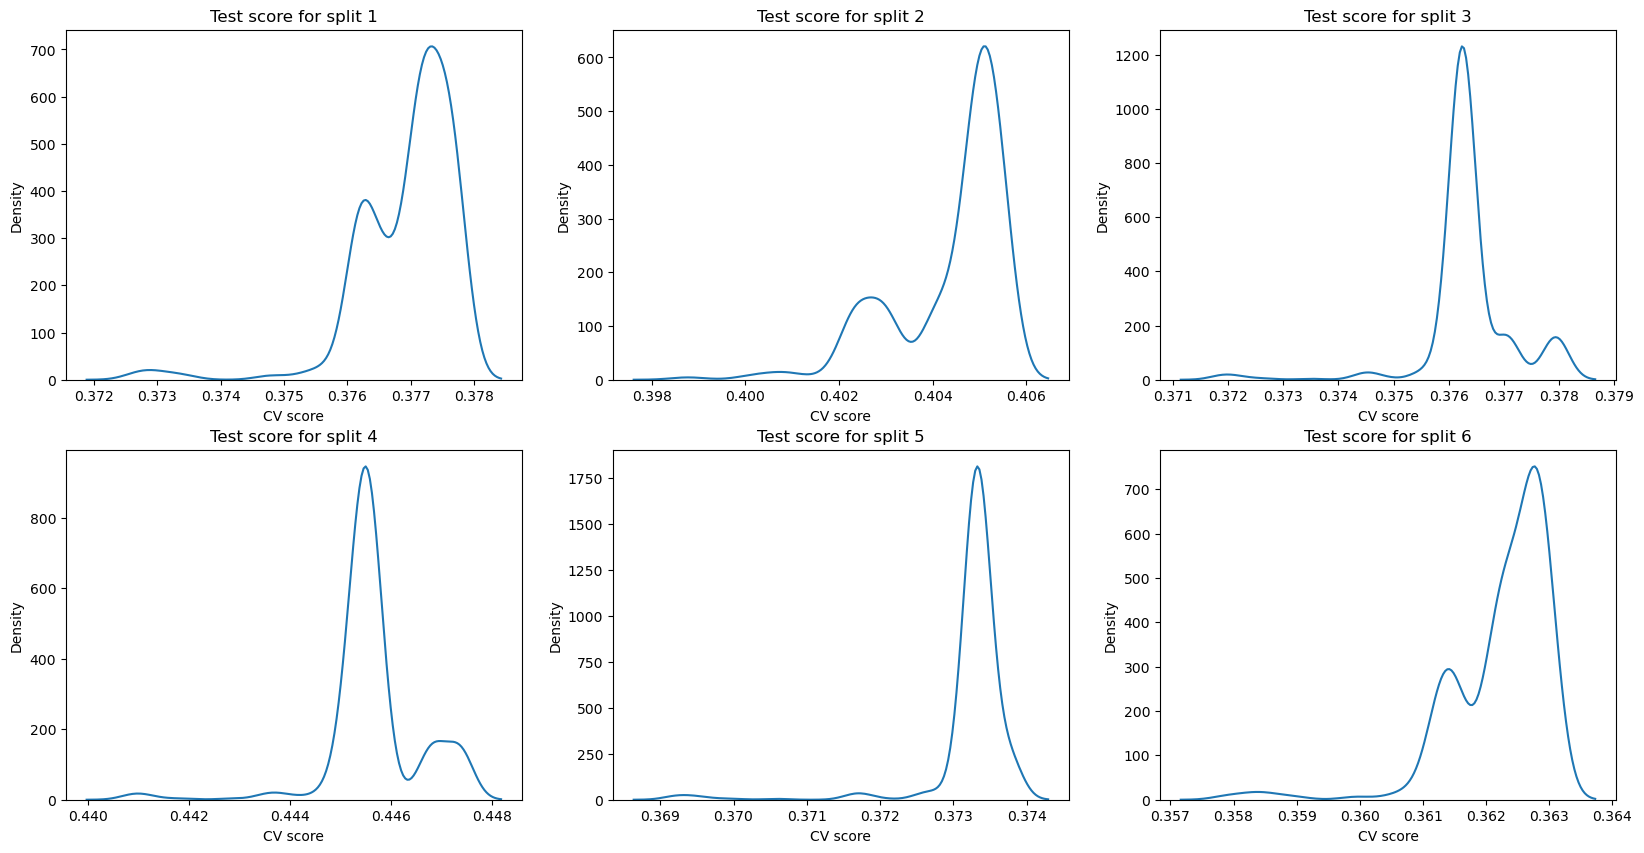

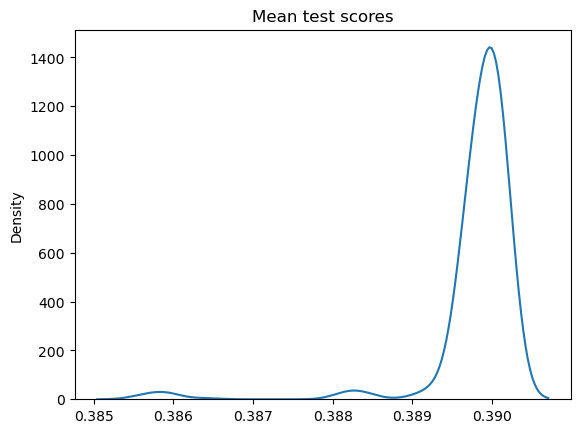

In [221]:
fig,axs=plt.subplots(nrows=2,ncols=3,figsize=(20,10))

for i in range(6):
    row=int(i/3)
    col=(i%3)
    
    sns.kdeplot(fine_tuner.cv_results_[f'split{i}_test_score'],ax=axs[row,col])
    axs[row,col].set_title(f'Test score for split {i+1}')
    axs[row,col].set_xlabel("CV score")
   
plt.show() 

plt.title("Mean test scores")
sns.kdeplot(fine_tuner.cv_results_['mean_test_score']) 
plt.show() 

Spored ova gledame deka rezultatite se generalno loshi za site parametri, sho znachit deka parametrite se loshi. Toa pak e chudno deka sepak SVR so kernel=linear e konveksna funkcija, sho znachit imat eden minimum, a toj minimum ilustrativno vidovme deka se naoga kaj  pomali vrednosti na C i pogolemi vrednosti za epsilon. 

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/pytho

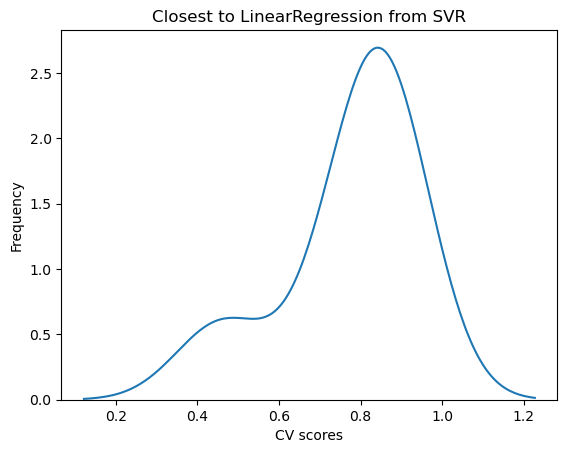

In [222]:
lin_svm=SVR(kernel='linear',max_iter=int(10e6),C=10e6,epsilon=0,)
cvs=cross_val_score(lin_svm,X_tr_scalled,y_tr,cv=6)

plt.title("Closest to LinearRegression from SVR")
plt.xlabel("CV scores")
plt.ylabel("Frequency")

sns.kdeplot(cvs)
plt.show()

Spored ova gleadme deka tie parametri sho go prat SVR da se ponashat kako LinearnaRegresija se dobri samo za test datasetot, dodeka on average kako shto gledame od grafikot se katastrofa. Znachit imame sreka so LinearRegression deka se pogodil test datasetot, inch spored grafikot e mnogu losh. 

Druga rabota mozhna e deka pogolem del od datasetot mu trebat za da se najdat dobrite hyperparametri. Vo smisla ko ke ojme so linear regression na train datasetot i ke go fitnime, toj nemat hyperparametri, taka da weightojte sho gi proizvedvit se tochno od train datasetot, cel. Imam pretpostavka deka to sho gledat dosta mnogu od datasetot, pri izbor na parametrite imat golemo vlijanie vrz rezultatot koj go postignuva nad test datasetot. 

# Cross validation so pogolem Kfold 

Pretpostavkata ke ja testirame preku cross validation so pogolem folds t.s. pogolem del (90%) od datasetot ke se iskoristit za treniranje na modelot. 

In [223]:

svm=SVR(kernel='linear',max_iter=int(10e4))
fine_tuner_loo=GridSearchCV(
    estimator=svm,
    param_grid={
        "C":C_VALS,
        "epsilon":[e*y_tr.min() for e in ERR_COEF ]
    },
    cv=10,
    scoring=house_pricing_metric,
    n_jobs=-1
)
fine_tuner_loo.fit(X_tr_scalled,y_tr)

GridSearchCV(cv=10, estimator=SVR(kernel='linear', max_iter=100000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 4.09491506e-02, 1.67683294e-02, 6.86648845e-03,
       2.81176870e-03, 1.15139540e-03, 4.71486636e-04, 1.93069773e-04,
       7.90604321e-05, 3.23745754e-05, 1.32571137e-05, 5.42867544e-06,
       2.22299648e-06, 9.10298178e-07, 3.72759372e-07, 1.52641797e-07,
       6.25055193e...
       3.08884360e-17, 1.26485522e-17, 5.17947468e-18, 2.12095089e-18,
       8.68511374e-19, 3.55648031e-19, 1.45634848e-19, 5.96362332e-20,
       2.44205309e-20, 1.00000000e-20]),
                         'epsilon': [0.0, 3877.7777777777774, 7755.555555555555,
                                     11633.333333333332, 15511.11111111111,
                                     19388.88888888889, 23266.666666666664,
                                     27144.44444444444, 31022.22222222222,
                                     34900.0]},
             scoring=make_scorer(rmse_logs, response_method='predict'))

In [224]:
fine_tuner_loo.best_score_

0.38929742181014454

In [225]:
best_est=fine_tuner_loo.best_estimator_
best_est.fit(X_tr_scalled,y_tr)

SVR(C=4.498432668969457e-16, epsilon=3877.7777777777774, kernel='linear',
    max_iter=100000)

In [226]:
rmse_logs(y_test,best_est.predict(X_test_scalled))

0.43223241037204263

Spored rezultatot, pretpostavkata koja ja imavme e greshna. 

## Polynomial kernel 

Najprvin da vidime kolku mozhit da fitnit.  

In [282]:
x_tr2,x_val,y_tr2,y_val=train_test_split(X_tr_scalled,y_tr,test_size=.25)

In [267]:
GAMMA_VALS=np.logspace(start=1,stop=10,base=2)

In [289]:
errs=[]
for g in GAMMA_VALS:
    poly=SVR(kernel='poly',gamma=g,epsilon=0.0001,C=10e6)
    poly.fit(x_tr2,y_tr2)
    errs.append(rmse_logs(y_val,poly.predict(x_val)))

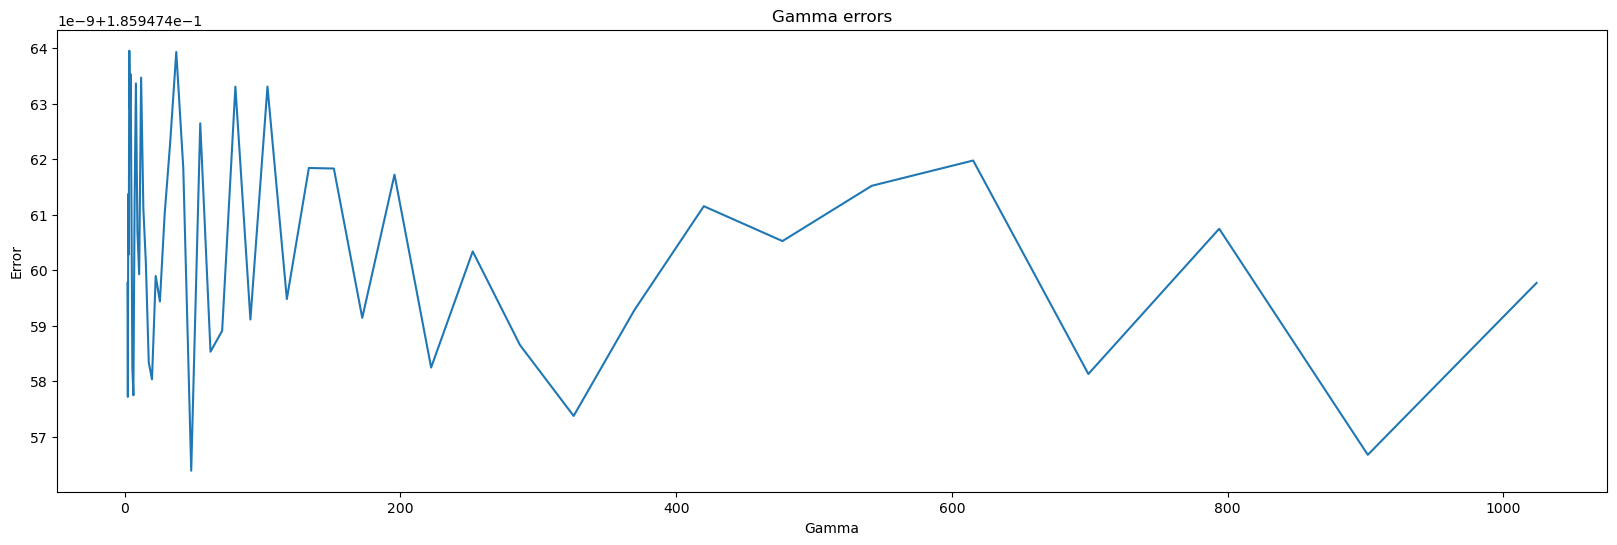

In [291]:
plt.figure(figsize=(20,6))

sns.lineplot(x=GAMMA_VALS,y=errs)

plt.title("Gamma errors")
plt.ylabel("Error")
plt.xlabel("Gamma")

plt.show()  

In [ ]:
list(zip(GAMMA_VALS,errs))

## RBF kernel 

In [239]:
stds=data_pipe.transform(X_tr).std()
stds.min(),stds.max(),y_tr.std()

(0.058445305948142116, 10759.366197666997, 77263.5838622284)

In [245]:
C_VALS=np.concatenate([np.logspace(start=1,stop=10,base=0.1,num=30),np.logspace(start=1,stop=5,base=10,num=30)])
EPSILON_VALS=np.linspace(0,20,num=30)
GAMMA_VALS=np.concatenate([
    np.logspace(start=1,stop=10,base=0.1,num=30),
    np.logspace(start=1,stop=3,base=10,num=30)
])

Spored vairjansata na features + target col, pretpostavuvam deka pogolemi vrednosti na gamma ke se generalno podobri, no vredat i malite da se proverat.

Najrpvin ke se obidime da go overfitnime modelot so razlichni gamma vrednosti. Na vakov nachin ke dobijame feel za kakva e devijacijata.

In [246]:
svm_rbf=SVR(kernel='rbf',max_iter=int(10e6),C=int(10e6),epsilon=0.001)

fine_tuner_gamma=GridSearchCV(
   estimator=svm_rbf,
   scoring=house_pricing_metric,
   cv=Kfolds,
   param_grid={
       "gamma": GAMMA_VALS
   },
   n_jobs=-1
)

fine_tuner_gamma.fit(X_tr_scalled,y_tr)

GridSearchCV(cv=6, estimator=SVR(C=10000000, epsilon=0.001, max_iter=10000000),
             n_jobs=-1,
             param_grid={'gamma': array([1.00000000e-01, 4.89390092e-02, 2.39502662e-02, 1.17210230e-02,
       5.73615251e-03, 2.80721620e-03, 1.37382380e-03, 6.72335754e-04,
       3.29034456e-04, 1.61026203e-04, 7.88046282e-05, 3.85662042e-05,
       1.88739182e-05, 9.23670857e-06, 4.52035366e-06, 2.21221629e-...
       4.89390092e+01, 5.73615251e+01, 6.72335754e+01, 7.88046282e+01,
       9.23670857e+01, 1.08263673e+02, 1.26896100e+02, 1.48735211e+02,
       1.74332882e+02, 2.04335972e+02, 2.39502662e+02, 2.80721620e+02,
       3.29034456e+02, 3.85662042e+02, 4.52035366e+02, 5.29831691e+02,
       6.21016942e+02, 7.27895384e+02, 8.53167852e+02, 1.00000000e+03])},
             scoring=make_scorer(rmse_logs, response_method='predict'))

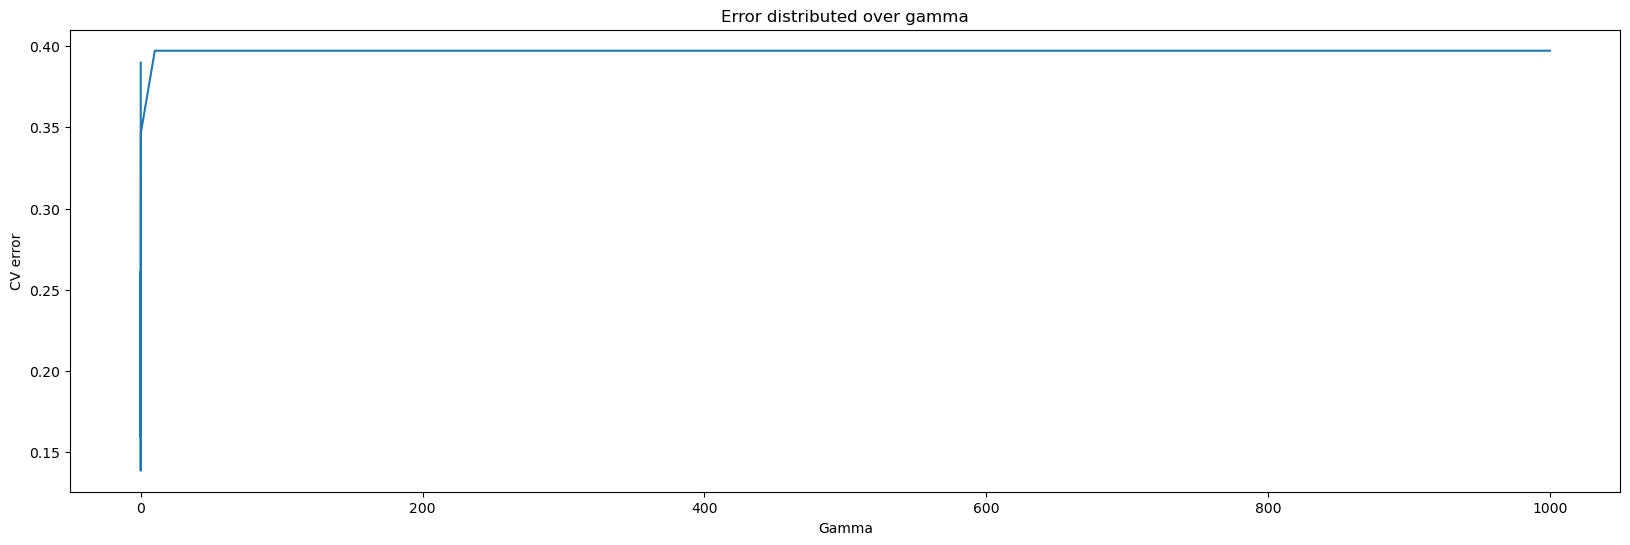

In [247]:
plt.figure(figsize=(20,6))
plt.title("Error distributed over gamma")
sns.lineplot(x=GAMMA_VALS,y=fine_tuner_gamma.cv_results_['mean_test_score'])
plt.xlabel("Gamma")
plt.ylabel("CV error")
plt.show()

Rezultative tuka indiciraat deka pomali gamma vrednosti, odnosno pogolema varijansa, podobro se spravuvat so datasetot. Problemot tuka spored meene e deka koristime cross validaiton, bidjeki toj testirat i kolku dobro generalizirat, no vo momentov mene me interesirat samo da go overfitnime.

In [248]:
x_tr2,x_val,y_tr2,y_val=train_test_split(X_tr_scalled,y_tr,test_size=.25,random_state=42)

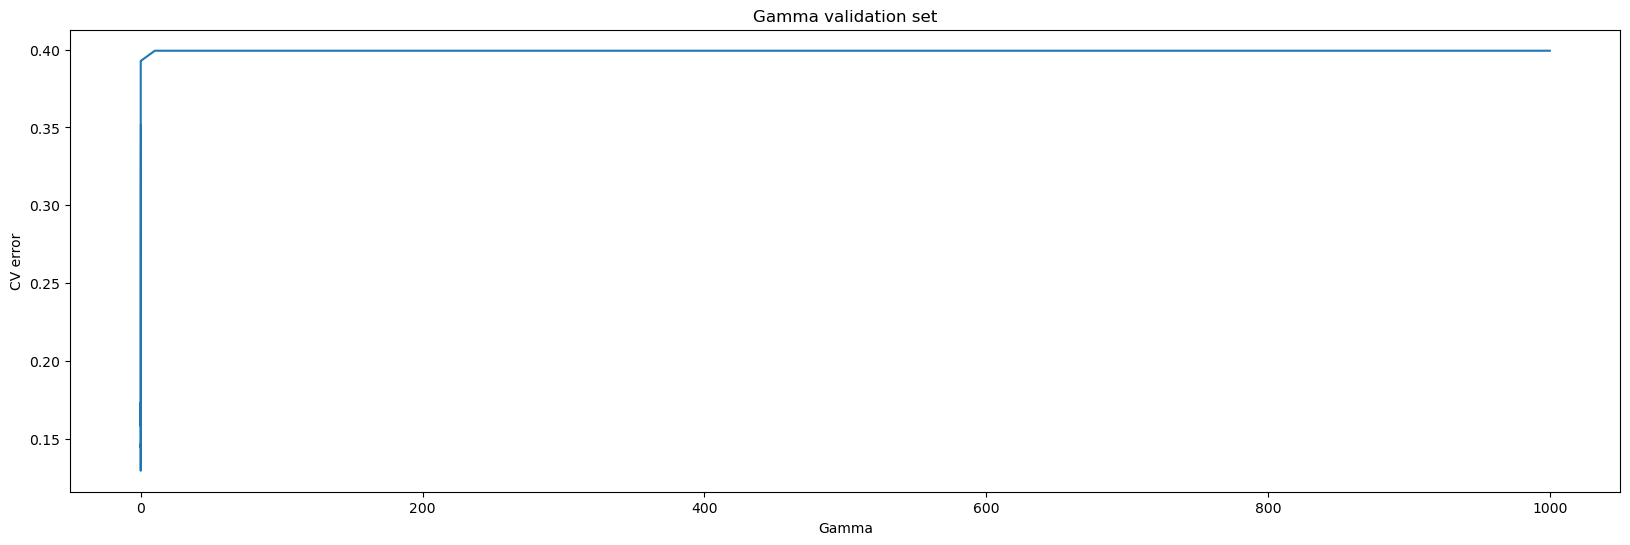

In [249]:
errs=[]
for gamma in GAMMA_VALS:
    svm_rbf=SVR(kernel='rbf',max_iter=int(10e6),C=int(10e6),epsilon=0.001,gamma=gamma)
    svm_rbf.fit(x_tr2,y_tr2)
    errs.append(rmse_logs(y_val,svm_rbf.predict(x_val)))

plt.figure(figsize=(20,6))

plt.title("Gamma validation set")
plt.xlabel("Gamma")
plt.ylabel("CV error")

plt.plot(GAMMA_VALS,errs)
plt.show()

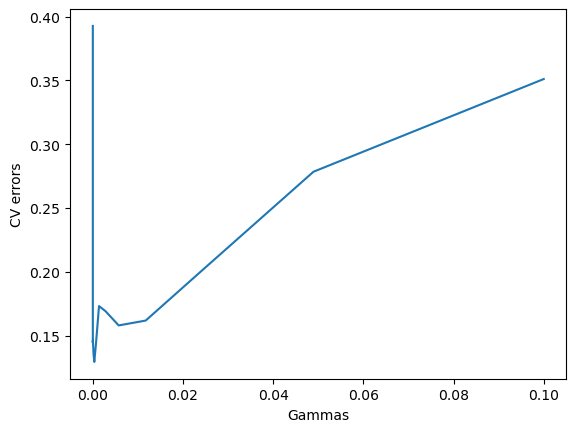

In [250]:
small_gamams=[g for g in list(zip(GAMMA_VALS,errs)) if g[0] <=0.1] 
small_gamams=np.array(small_gamams)

plt.plot(small_gamams[:,0],small_gamams[:,1])

plt.xlabel("Gammas")
plt.ylabel("CV errors")

plt.show() 

In [251]:
best_gamma=sorted(small_gamams.tolist(),key=lambda x: x[1])[0][0]
best_gamma

0.0003290344562312668

Ova mi ukazhuva deka datasetot imat dosta golema varijansa (deka gamma e inverse na varijansata). Prashanjeto e dali ke mozhit da generalizirat dobro, iako najcesto mali vrednosti za gamma znachat podobro generaliziranje. 

Tuka opravduvam koristenje na cross validation deka sepak C-regularization parametarot e mnogu visok sho znachit deka ke se obidit da ja fitnit datata sho e mozhno pojke, sepak to ni beshe celta. Sega treba da izberime C t.s. nemat premnogu da overfitnit. 

In [252]:
fine_tunner_C=GridSearchCV(
    estimator=SVR(kernel='rbf',max_iter=int(10e4),gamma=best_gamma),
    cv=Kfolds,
    scoring=house_pricing_metric,
    param_grid={
        'C':C_VALS,
        "epsilon": EPSILON_VALS
    },
    n_jobs=-1
)
fine_tunner_C.fit(X_tr_scalled,y_tr)

GridSearchCV(cv=6, estimator=SVR(gamma=0.0003290344562312668, max_iter=100000),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 4.89390092e-02, 2.39502662e-02, 1.17210230e-02,
       5.73615251e-03, 2.80721620e-03, 1.37382380e-03, 6.72335754e-04,
       3.29034456e-04, 1.61026203e-04, 7.88046282e-05, 3.85662042e-05,
       1.88739182e-05, 9.23670857e-06, 4.52035366e-06, 2.21221629e-06,...
                         'epsilon': array([ 0.        ,  0.68965517,  1.37931034,  2.06896552,  2.75862069,
        3.44827586,  4.13793103,  4.82758621,  5.51724138,  6.20689655,
        6.89655172,  7.5862069 ,  8.27586207,  8.96551724,  9.65517241,
       10.34482759, 11.03448276, 11.72413793, 12.4137931 , 13.10344828,
       13.79310345, 14.48275862, 15.17241379, 15.86206897, 16.55172414,
       17.24137931, 17.93103448, 18.62068966, 19.31034483, 20.        ])},
             scoring=make_scorer(rmse_logs, response_method='predict'))

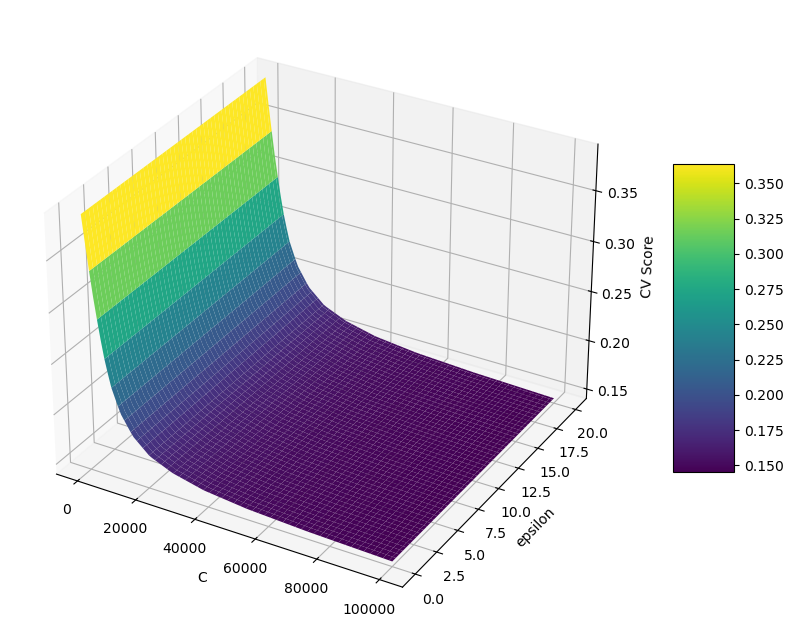

In [253]:
plot_3d_cv_results(fine_tuner=fine_tunner_C,xs=C_VALS,ys=EPSILON_VALS,x_name='C',y_name='epsilon')

Imat pretpostavka tuka zaradi malata vrednost na gamma, iako sho taa mala vrednost najdobri rezultati davat, predizvikuva modelot eptem da barat C da porasnit za da mozhit da fitnit. Ova pretpostavka ke ja potvrdime preku ushte eden grid search na site 3 parametri. 

In [254]:
fine_tunner_gamma_C=sklearn.model_selection.HalvingGridSearchCV(
    estimator=SVR(kernel='rbf',max_iter=int(10e4),gamma=best_gamma),
    cv=Kfolds,
    scoring=house_pricing_metric,
    param_grid={
        'C':C_VALS,
        "epsilon": EPSILON_VALS,
        'gamma': GAMMA_VALS
    },
    n_jobs=-1
)
fine_tunner_gamma_C.fit(X_tr_scalled,y_tr)

HalvingGridSearchCV(cv=6,
                    estimator=SVR(gamma=0.0003290344562312668, max_iter=100000),
                    n_jobs=-1,
                    param_grid={'C': array([1.00000000e-01, 4.89390092e-02, 2.39502662e-02, 1.17210230e-02,
       5.73615251e-03, 2.80721620e-03, 1.37382380e-03, 6.72335754e-04,
       3.29034456e-04, 1.61026203e-04, 7.88046282e-05, 3.85662042e-05,
       1.88739182e-05, 9.23670857e-06, 4.52035366e-06, 2.212216...
       4.89390092e+01, 5.73615251e+01, 6.72335754e+01, 7.88046282e+01,
       9.23670857e+01, 1.08263673e+02, 1.26896100e+02, 1.48735211e+02,
       1.74332882e+02, 2.04335972e+02, 2.39502662e+02, 2.80721620e+02,
       3.29034456e+02, 3.85662042e+02, 4.52035366e+02, 5.29831691e+02,
       6.21016942e+02, 7.27895384e+02, 8.53167852e+02, 1.00000000e+03])},
                    scoring=make_scorer(rmse_logs, response_method='predict'))

In [255]:
fine_tunner_gamma_C.best_params_

{'C': 3039.195382313198, 'epsilon': 20.0, 'gamma': 57.36152510448679}

Inicijalnata pretpostavka sho ja imav, odnosno pretpostavkata deka pogolemi gamma vrednosti ke se podobri, ispadna da e tochna. Vo validaciskoto mnozeshtov ispadna da e greshna, no to ne ja davat vistinskata slika, bidejki tamu se trudevme sho e mozhno pojke da go overfitnime, so cel da gi vidime granicite koi mozhit da odat preformansite na modelot. 

In [256]:
fine_tunner_gamma_C.best_score_

0.39149141021234374

Sepak e dosta losh modelot na cross validation.

In [257]:
best_rbf=fine_tunner_gamma_C.best_estimator_
best_rbf.fit(X_tr_scalled,y_tr)

SVR(C=3039.195382313198, epsilon=20.0, gamma=57.36152510448679, max_iter=100000)

In [258]:
rmse_logs(y_test,best_rbf.predict(X_test_scalled))

0.43229082712891836

Vo prethodniot slucaj so linearna regresija mislam deka visokata tochnost se dolzhit na faktot deka ne e merena na cross validation, no vo primermite pogore, so linear kernel, vidovme deka sepak ne davat dobri rezultati vo odnos na cross validationot, sho znachit deka mu trebat mnogu data za da se fitnit ko sho trebat.

Isto kako i vo linear kernel, ke upotrebime cv so pogolem fold, so cel da dobijame pogolem del od datasetot vo train delot. 

In [259]:
fine_tunner_gamma_C_loo=sklearn.model_selection.HalvingGridSearchCV(
    estimator=SVR(kernel='rbf',max_iter=int(10e4),gamma=best_gamma),
    cv=10,
    scoring=house_pricing_metric,
    param_grid={
        'C':C_VALS,
        "epsilon": EPSILON_VALS,
        'gamma': GAMMA_VALS
    },
    n_jobs=-1 
)
fine_tunner_gamma_C_loo.fit(X_tr_scalled,y_tr)

HalvingGridSearchCV(cv=10,
                    estimator=SVR(gamma=0.0003290344562312668, max_iter=100000),
                    n_jobs=-1,
                    param_grid={'C': array([1.00000000e-01, 4.89390092e-02, 2.39502662e-02, 1.17210230e-02,
       5.73615251e-03, 2.80721620e-03, 1.37382380e-03, 6.72335754e-04,
       3.29034456e-04, 1.61026203e-04, 7.88046282e-05, 3.85662042e-05,
       1.88739182e-05, 9.23670857e-06, 4.52035366e-06, 2.21221...
       4.89390092e+01, 5.73615251e+01, 6.72335754e+01, 7.88046282e+01,
       9.23670857e+01, 1.08263673e+02, 1.26896100e+02, 1.48735211e+02,
       1.74332882e+02, 2.04335972e+02, 2.39502662e+02, 2.80721620e+02,
       3.29034456e+02, 3.85662042e+02, 4.52035366e+02, 5.29831691e+02,
       6.21016942e+02, 7.27895384e+02, 8.53167852e+02, 1.00000000e+03])},
                    scoring=make_scorer(rmse_logs, response_method='predict'))

In [260]:
fine_tunner_gamma_C_loo.best_score_

0.3919112995493599

In [261]:
best_est=fine_tunner_gamma_C_loo.best_estimator_
best_est.fit(X_tr_scalled,y_tr)

SVR(C=126.89610031679221, epsilon=6.8965517241379315, gamma=204.33597178569417,
    max_iter=100000)

In [262]:
rmse_logs(y_test,best_est.predict(X_test_scalled))

0.4322818211837901

Isto i tuka kako vo i linear kernel. 